In [ ]:
#!pip install xlwt
#!pip install sentence_transformers
#!pip install factor-analyzer
#!pip install scipy
#!pip install tensorflow_hub

# Below I connect this notebook to my google drive, where I created a shortcut to the folder. @nigel, in your case,
# you may have to change the actual directory through the os.chdir() command. If you want to test where this notebook is
# actually located, just use the "ls" command in an empy cell as below.

from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import os
os.chdir('/content/drive/My Drive/01 Pseudo_factor-analysis/02 Johnson (2014) facet level 300 items')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 875.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 648.3 kB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor-analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42565 sha256=ef443790415d2a0814a6ae3879ac0a42bade210bc234441f1edf63ff0b782220
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor-analyzer
Mounted at /content/drive


In [ ]:
#check if notebook is in the right position (it should be in the folder with the D_matrices/ subfolder)
!ls

 Analyses.r		   'NEO PFA and EFA at once.ipynb'   Results_after_ordering
 D_matrices		   'Old files'			     Results_before_ordering
'Johnson IPIPitemkey.xls'   PFA_and_EFA.r		    'Results loadings overview!.xlsx'


# Part 0: Prepare empirical data for analyses
- read in data
- calculate facet-level scores
- store facet-level responses


In [ ]:
from huggingface_hub import snapshot_download

In [1]:
import pandas as pd
import numpy as np
import xlwt
# read in file with items text etc.
df_items = pd.read_excel('Johnson IPIPitemkey.xls')
df_items.head()

ModuleNotFoundError: No module named 'xlwt'

# Part I: Create embeddings for PFA

Below we do the folowing:
- Group item in a single list per facet
- Calculate item embeddings
- Reverse item embeddings (if necessary)
- Aggregate item embeddings to create facet embedding
- Calculate facet list embedding
- Compute cosine similarities
- Store results

In [ ]:
# Calculate item embeddings
# Reverse item embeddings if necessary

# To make the code shorter and sightly more efficient we loop through the models that we are using in the paper.
# First we create a list of models.
models = ['Dimitre/universal-sentence-encoder',
          'nli-distilroberta-base-v2',
          'all-mpnet-base-v2',
          'sentence-t5-base',
          'sentence-transformers/stsb-distilroberta-base-v2',
          'microsoft/MiniLM-L12-H384-uncased',
          'dwulff/mpnet-personality']

sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2

# Import the necessary libraries and functions
from sentence_transformers import SentenceTransformer, util
from huggingface_hub import snapshot_download
import tensorflow_hub as hub

# Create an empty data frame, which we will then populate with the different type of embeddings
facet_embeddings_sentences = pd.DataFrame()

for mod in models:
  if mod == 'Dimitre/universal-sentence-encoder':
    item_embed = [] #create list for item-level embed
    item_embed_rev = [] #create list for item-level embed accounting for sign
    model_path = snapshot_download(repo_id = 'Dimitre/universal-sentence-encoder')
    model = hub.KerasLayer(handle = model_path)
      #encode items
    for item in range(0,len(df_items['Full#'])): #loop over all the items
      item_embed.append(model([df_items['Item'].iloc[item]]).numpy().flatten())
      if df_items['Sign'].iloc[item][0] == '-': #if items is negatively keyed, reverse the embeddings
        item_embed_rev.append(model([df_items['Item'].iloc[item]]).numpy().flatten()*-1)
      else:
        item_embed_rev.append(model([df_items['Item'].iloc[item]]).numpy().flatten())
    df_items[mod + '_embeddings'] = item_embed #then, we append the two item-level embeddings list and give them a name based on the model we used
    df_items[mod + '_embeddings_rev'] = item_embed_rev
  else:
    model = SentenceTransformer(mod) #call the model
    item_embed = [] #create list for item-level embed
    item_embed_rev = [] #create list for item-level embed accounting for sign
    for item in range(0,len(df_items['Full#'])): #loop over all the items
    #encode items
      item_embed.append(model.encode(df_items['Item'].iloc[item]))
      if df_items['Sign'].iloc[item][0] == '-': #if items is negatively keyed, reverse the embeddings
        item_embed_rev.append(model.encode(df_items['Item'].iloc[item])*-1)
      else:
        item_embed_rev.append(model.encode(df_items['Item'].iloc[item]))
    df_items[mod + '_embeddings'] = item_embed #then, we append the two item-level embeddings list and give them a name based on the model we used
    df_items[mod + '_embeddings_rev'] = item_embed_rev

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/3.19k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.26k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/8.22M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
# To avoid having too long names for the output datsets, we create a list of names, which we will then use to save the embedding cosine matrices
# make sure that the names here are meaningful and aligned with those of the one in the cell above.
model_short = ['use_dan', 'distilroberta', 'mpnet', 't5', 'roberta', 'miniLM', 'psych']

# Below, we loop over the different models we use for the study and compute the cosine sim. matrices.
for mod in range(0, len(models)):
  # create temporary empty lists for the item and one-pop method embeddings
  facet_embeddings_item = []
  facet_embeddings_item_rev = []
  facet_embeddings_sentences = []

  #Loop over the different facets (called key) to aggregate the item-level embeddings
  for sub_facet in df_items['Facet'].unique():
    # mean across item-level embeddings per facet
    facet_embeddings_item.append(df_items[df_items['Facet'] == sub_facet][models[mod] + '_embeddings'].mean())
    # mean across items-level embeddings per facet accounting for item sign
    facet_embeddings_item_rev.append(df_items[df_items['Facet'] == sub_facet][models[mod] + '_embeddings_rev'].mean())
    #get sentence embeddings for the one-pop method
    facet_embeddings_sentences.append(''.join(df_items[df_items['Facet'] == sub_facet]['Item']))
    # call model for one-pop method embeddings
  if models[mod] == 'Dimitre/universal-sentence-encoder':
    model_path = snapshot_download(repo_id = 'Dimitre/universal-sentence-encoder')
    model = hub.KerasLayer(handle = model_path)
    sentence_embeddings = model(facet_embeddings_sentences).numpy()
  else:
    model = SentenceTransformer(models[mod]) #call the model
    # calculate embeddings for one-pop method
    sentence_embeddings = model.encode(facet_embeddings_sentences)

  #create cosine similarity matrix for each embedding calculation approach
  cosine_similarities_item = util.pytorch_cos_sim(facet_embeddings_item,facet_embeddings_item).numpy()
  cosine_similarities_item_rev = util.pytorch_cos_sim(facet_embeddings_item_rev,facet_embeddings_item_rev).numpy()
  cosine_similarities_sentence = util.pytorch_cos_sim(sentence_embeddings,sentence_embeddings).numpy()
  #fill diagonal with 1. This is done to avoid efa functions reading the cosine matrix as covariance
  np.fill_diagonal(cosine_similarities_item,1)
  np.fill_diagonal(cosine_similarities_item_rev,1)
  np.fill_diagonal(cosine_similarities_sentence,1)

  #add perturbation to the cosine_similarity matrices



  #store results
  pd.DataFrame(cosine_similarities_item, columns = df_items['Facet'].unique(), index = df_items['Facet'].unique()).to_csv('./D_matrices/matrix_concatenated_item_'+model_short[mod]+'.csv', index = False)
  pd.DataFrame(cosine_similarities_item_rev, columns = df_items['Facet'].unique(), index = df_items['Facet'].unique()).to_csv('./D_matrices/matrix_concatenated_item_rev_'+model_short[mod]+'.csv', index = False)
  pd.DataFrame(cosine_similarities_sentence, columns = df_items['Facet'].unique(), index = df_items['Facet'].unique()).to_csv('./D_matrices/matrix_concatenated_'+model_short[mod]+'.csv', index = False)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  a = torch.tensor(a)


# Part II Conduct EFA and PFA:
## Note, this code was not used for the actual analyses and it's only here for showing purposes for Python-only users.
Below we do the following:
- Run Parallel Analysis for each of the produced cosine similarity matrices
- Conduct PFA based on the hypothesized number of factors for the HEXACO (6)
- Rotate using Promax
- Store the loadings for comparison with EFA


In [ ]:

def _HornParallelAnalysis(data, K=20, printEigenvalues=False, sample = None, percentile = 50):
    ################
    # Create a random matrix to match the dataset
    ################
    if data.shape[0] == data.shape[1]:
      if sample is None:
        n = 1000
      else:
        n = sample
      m = data.shape[1]
    else:
      n, m = data.shape
    # Set the factor analysis parameters
    fa = FactorAnalyzer(n_factors = 1, method='minres', rotation=None, use_smc=True)
    # Create arrays to store the values
    sumComponentEigens = []
    sumFactorEigens = []
    # Run the fit 'K' times over a random matrix
    for runNum in range(0, K):
      fa.fit(np.random.normal(size=(n, m)))
      sumComponentEigens.append(fa.get_eigenvalues()[0])
      sumFactorEigens.append(fa.get_eigenvalues()[1])
        # Average over the number of runs

    avgComponentEigens = np.percentile(sumComponentEigens, percentile, axis = 0)
    avgFactorEigens = np.percentile(sumFactorEigens, percentile, axis = 0)

    ################
    # Get the eigenvalues for the fit on supplied data
    ################
    fa.fit(data)
    dataEv = fa.get_eigenvalues()
    # Set up a scree plot
    plt.figure(figsize=(8, 6))

    ################
    ### Print results
    ################
    if printEigenvalues:
        print('Principal component eigenvalues for random matrix:\n', avgComponentEigens)
        print('Factor eigenvalues for random matrix:\n', avgFactorEigens)
        print('Principal component eigenvalues for data:\n', dataEv[0])
        print('Factor eigenvalues for data:\n', dataEv[1])
    # Find the suggested stopping points
    suggestedFactors = sum((dataEv[1] - avgFactorEigens) > 0)
    suggestedComponents = sum((dataEv[0] - avgComponentEigens) > 0)
    print('Parallel analysis suggests that the number of factors = ', suggestedFactors , ' and the number of components = ', suggestedComponents)


    ################
    ### Plot the eigenvalues against the number of variables
    ################
    # Line for eigenvalue 1
    plt.plot([0, m+1], [1, 1], 'k--', alpha=0.3)
    # For the random data - Components
    plt.plot(range(1, m+1), avgComponentEigens, 'b', label='PC - random', alpha=0.4)
    # For the Data - Components
    plt.scatter(range(1, m+1), dataEv[0], c='b', marker='o')
    plt.plot(range(1, m+1), dataEv[0], 'b', label='PC - data')
    # For the random data - Factors
    plt.plot(range(1, m+1), avgFactorEigens, 'g', label='FA - random', alpha=0.4)
    # For the Data - Factors
    plt.scatter(range(1, m+1), dataEv[1], c='g', marker='o')
    plt.plot(range(1, m+1), dataEv[1], 'g', label='FA - data')
    plt.title('Parallel Analysis Scree Plots', {'fontsize': 20})
    plt.xlabel('Factors/Components', {'fontsize': 15})
    plt.xticks(ticks=range(1, m+1), labels=range(1, m+1))
    plt.ylabel('Eigenvalue', {'fontsize': 15})
    plt.legend()
    plt.show();


distilroberta
Parallel analysis suggests that the number of factors =  6  and the number of components =  6


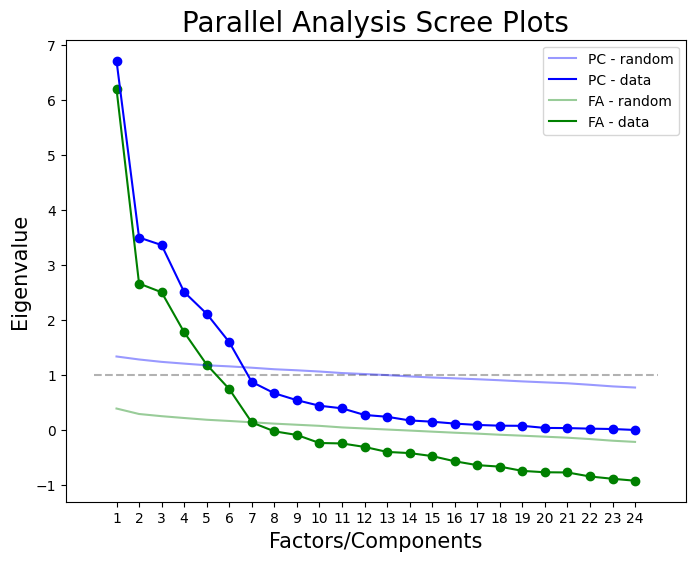

mpnet
Parallel analysis suggests that the number of factors =  6  and the number of components =  6


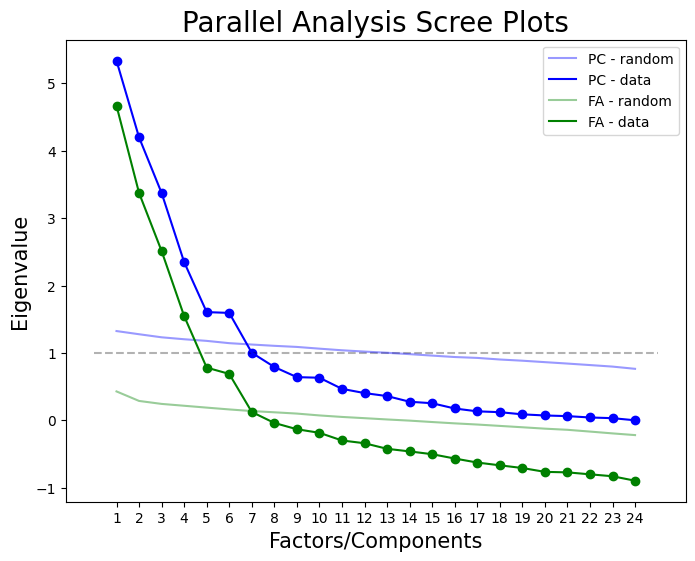

t5
Parallel analysis suggests that the number of factors =  6  and the number of components =  6


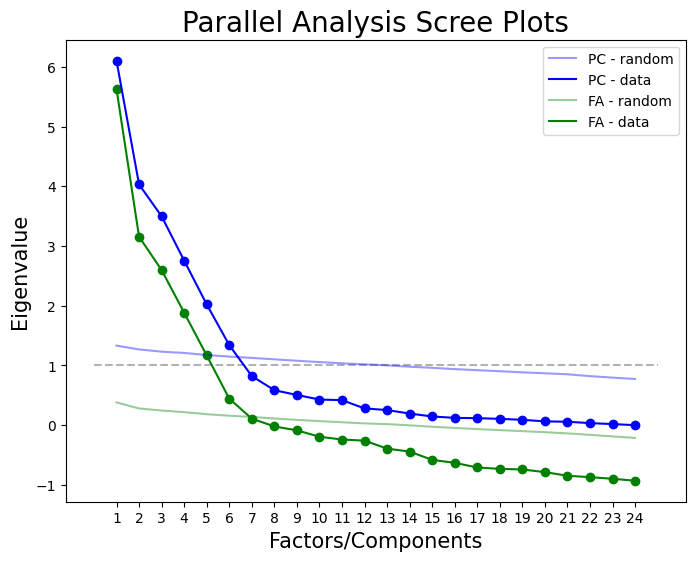

roberta
Parallel analysis suggests that the number of factors =  6  and the number of components =  6


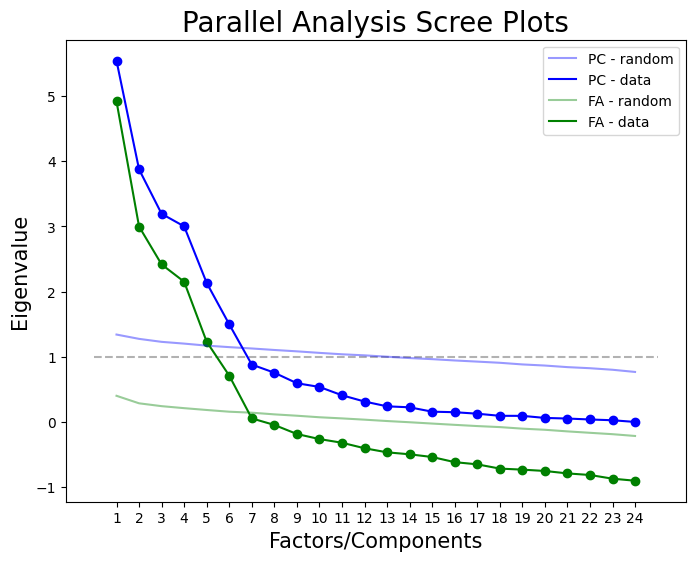

miniLM
Parallel analysis suggests that the number of factors =  7  and the number of components =  5


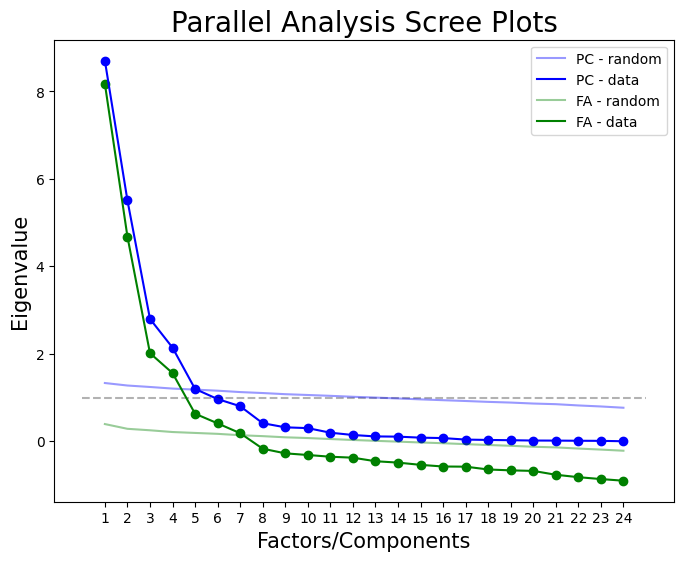

In [ ]:
#Evaluate model specific PA results for the item (no revers) aggregated embeddings
for mod in model_short:
  print(mod)
  temp_df = pd.read_csv(filepath_or_buffer='./D_matrices/matrix_concatenated_item_'+mod+'.csv')
  _HornParallelAnalysis(temp_df, K = 50, sample = None, percentile = 95)

distilroberta
Parallel analysis suggests that the number of factors =  5  and the number of components =  4


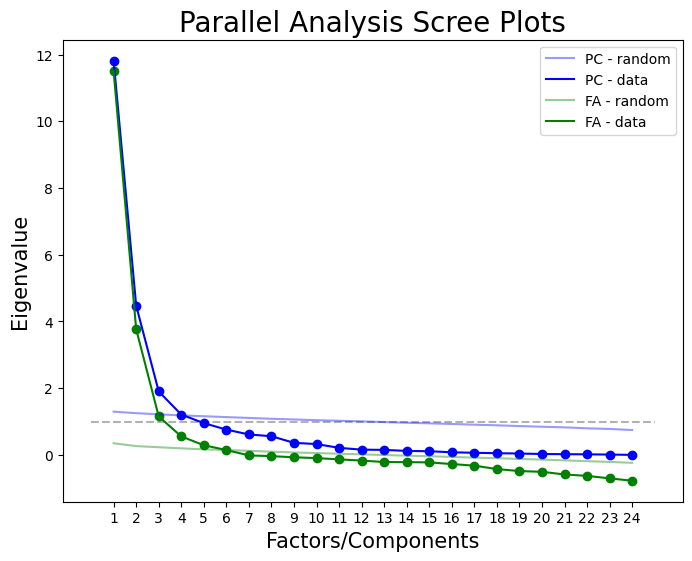

mpnet
Parallel analysis suggests that the number of factors =  6  and the number of components =  4


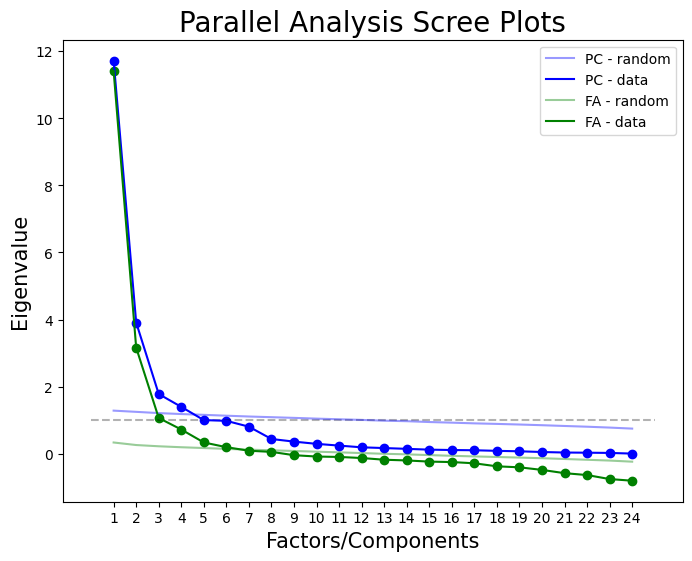

t5
Parallel analysis suggests that the number of factors =  3  and the number of components =  3


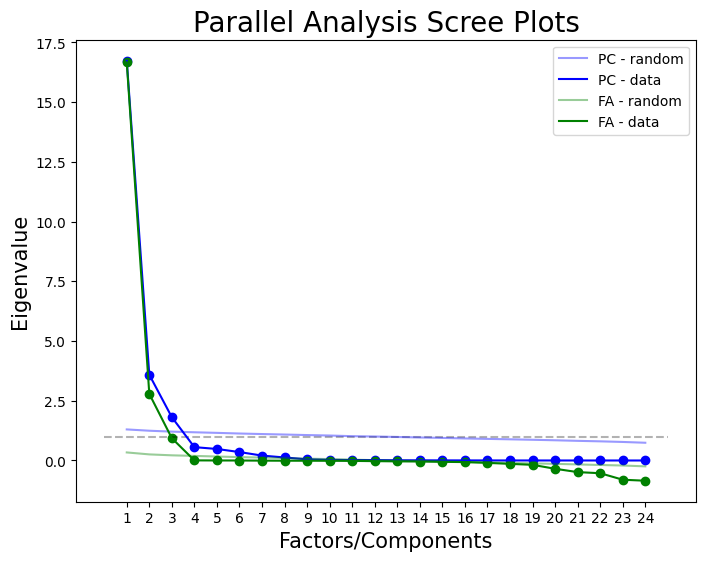

roberta
Parallel analysis suggests that the number of factors =  6  and the number of components =  4


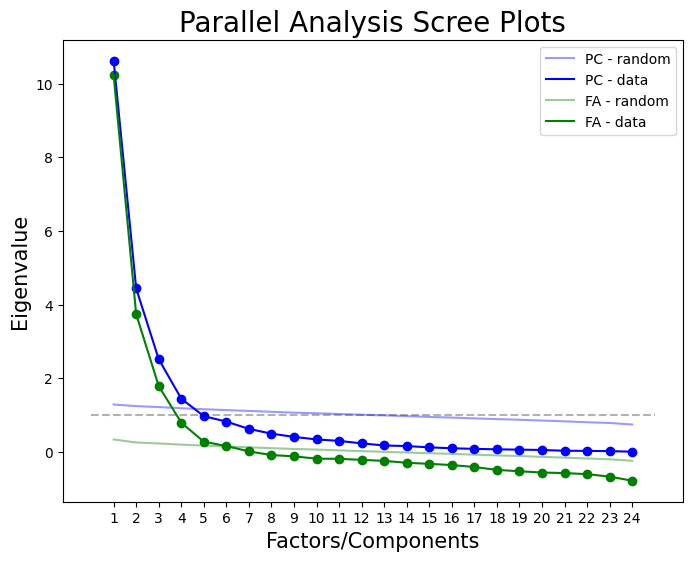

miniLM
Parallel analysis suggests that the number of factors =  9  and the number of components =  2


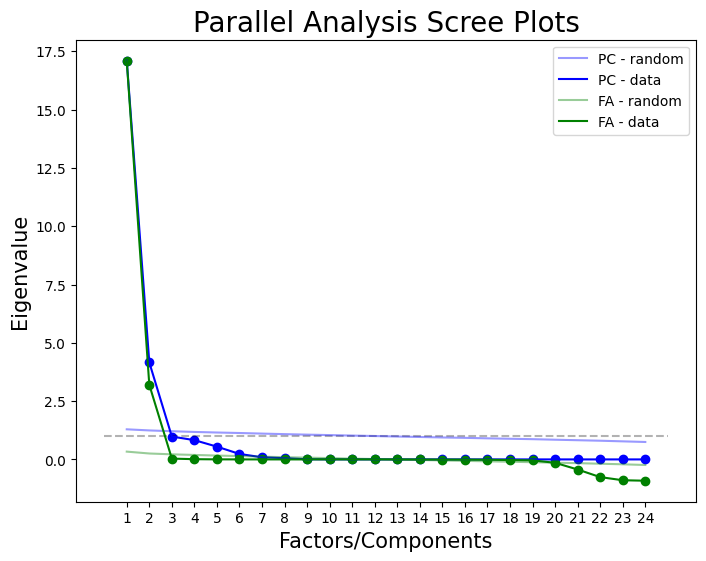

In [ ]:
#Evaluate model specific PA results for the item (no revers) aggregated embeddings
for mod in model_short:
  print(mod)
  temp_df = pd.read_csv(filepath_or_buffer='./D_matrices/matrix_concatenated_item_rev_'+mod+'.csv')
  _HornParallelAnalysis(temp_df, K = 50, sample = None)

distilroberta
Parallel analysis suggests that the number of factors =  7  and the number of components =  6


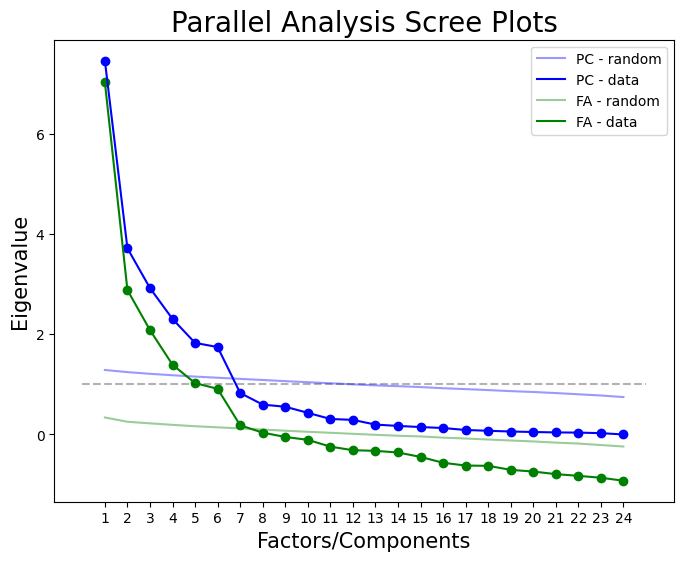

mpnet
Parallel analysis suggests that the number of factors =  7  and the number of components =  6


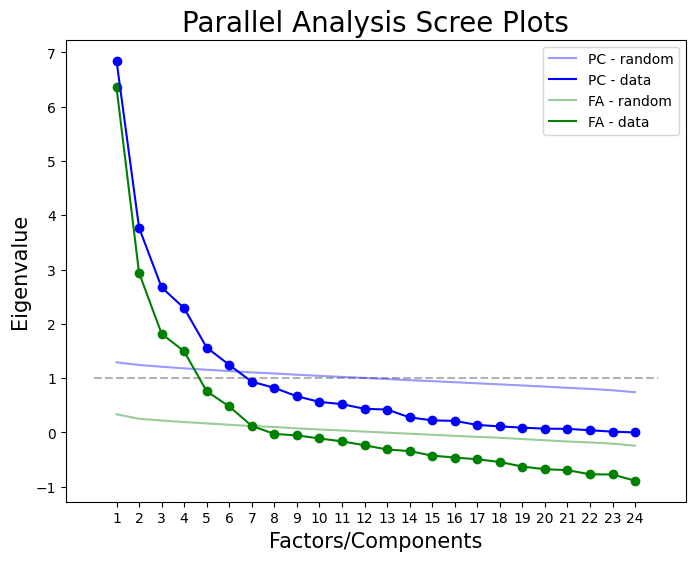

t5
Parallel analysis suggests that the number of factors =  6  and the number of components =  6


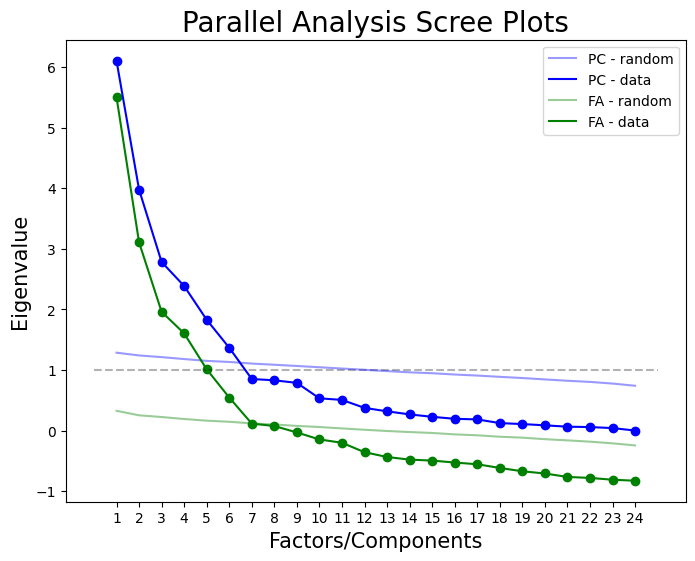

roberta
Parallel analysis suggests that the number of factors =  7  and the number of components =  6


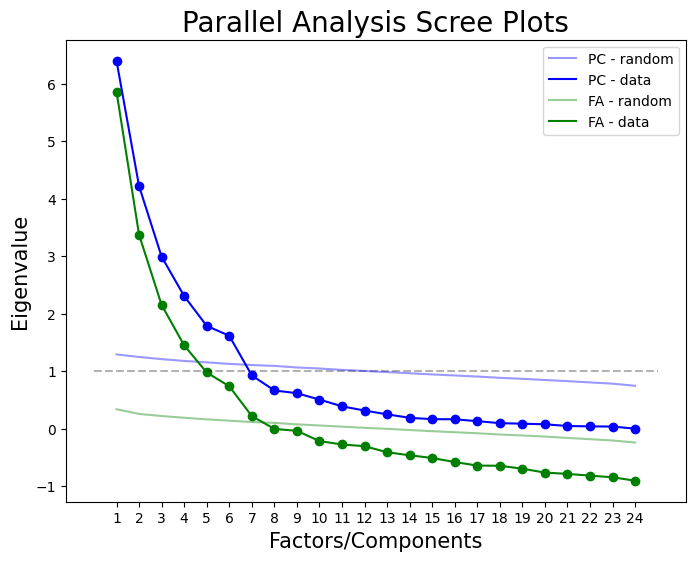

miniLM
Parallel analysis suggests that the number of factors =  7  and the number of components =  6


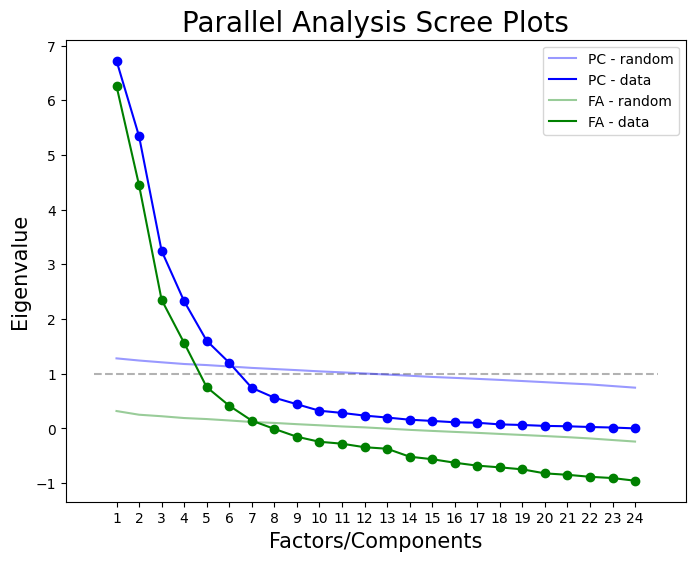

In [ ]:
#Evaluate model specific PA results for the item (no revers) aggregated embeddings
for mod in model_short:
  print(mod)
  temp_df = pd.read_csv(filepath_or_buffer='./D_matrices/matrix_concatenated_'+mod+'.csv')
  _HornParallelAnalysis(temp_df, K = 50, sample = None)

In [ ]:
efa_emp = FactorAnalyzer(n_factors = 6, rotation = 'promax').fit(df_new)
pfa = FactorAnalyzer(n_factors=6, rotation = 'promax').fit(cosine_similarities_sentence)
pd.concat([pd.DataFrame(np.round(efa_emp.loadings_,3), index = df_items['key'].unique()), pd.DataFrame(np.round(pfa.loadings_,3), index = df_items['key'].unique())], axis = 1)

,0,1,2,3,4,5,0,1,2,3,4,5
Fear,0.060,0.047,0.117,0.711,-0.190,-0.123,-0.263,0.489,0.021,-0.063,0.038,0.652
Depe,0.203,0.063,-0.088,0.332,-0.059,0.061,0.765,0.093,0.068,-0.097,0.224,-0.094
Expr,-0.177,-0.091,0.175,0.678,-0.030,0.111,0.224,-0.096,0.048,0.083,0.764,0.022
Gent,-0.117,0.157,-0.044,0.570,0.143,-0.028,0.839,0.017,0.113,0.179,0.024,-0.009
Prud,0.099,0.371,0.087,0.057,0.120,-0.098,0.287,-0.160,0.584,0.241,-0.250,0.151
Crea,0.200,0.315,0.025,-0.029,0.049,0.049,0.137,0.787,0.488,0.182,0.007,-0.239
Sent,-0.238,0.783,-0.179,0.112,-0.038,-0.001,-0.070,0.271,-0.315,0.825,0.016,0.197
Gree,0.543,-0.064,-0.212,0.053,0.057,-0.034,0.136,0.668,-0.181,-0.285,0.082,0.043
Live,0.596,0.075,0.059,-0.125,-0.085,-0.019,-0.234,-0.085,-0.055,-0.141,0.831,-0.295
Flex,0.518,0.115,-0.048,-0.086,0.000,0.048,0.659,-0.034,0.171,0.336,0.218,0.021
